In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
from scipy.stats import skew,boxcox,yeojohnson
import sklearn
from sklearn.preprocessing import LabelEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
np.random.seed(123)

/home/piotr/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [77]:
#Reading csv
df = pd.read_csv("../bank_marketing_weka_dataset.csv")

#Separate features
X = df.drop(['y'], axis=1)

#Target variable
y = df['y']

#Transform 'y' to binary
y = y.map(dict(yes=1, no=0))

#Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [78]:
#Continuos variables
conti = X.select_dtypes(include=np.number)

def skew_reduce(X, skewed):
    '''Applies boxcox or yeojohnson transform on skew vars'''
    for column in skewed:
        if X[column].min()>0:
            print(pd.Series(boxcox(X[column])[0]).skew(),f'{column} boxcox')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(boxcox(X[column])[0])
        else:
            print(pd.Series(yeojohnson(X[column])[0]).skew(),f'{column} yeojohnson')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(yeojohnson(X[column])[0])
            
def skew(X, conti):
    '''Calculates skewness of continuous variables in dataset. conti - var list
    returns columns with skewness>2'''
    skewed = []
    for column in conti.columns:
        if conti[column].skew()>2:
            skewed.append(column)
        #print(f'{column.capitalize()} skew = {conti[column].skew()}')
    return(skewed)

skew_train = skew(X_train, conti)

# Wstęp do uczenia maszynowego
## Podsumowanie projektu dla problemu klasyfikacji
Filip Chrzuszcz  
Piotr Fic

# Zbiór danych
### Bank marketing: https://www.mldata.io/dataset-details/bank_marketing/
### Zadanie klasyfikacji:

- predykcja czy klient zasubskrybuje usługę bankową

In [79]:
#Reading data
df = pd.read_csv("../bank_marketing_weka_dataset.csv")

# Eksploracja danych
### Oryginalny zbiór danych

In [80]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199.0,4,-1.0,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226.0,1,-1.0,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141.0,2,176.0,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341.0,1,330.0,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151.0,2,-1.0,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57.0,2,-1.0,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313.0,1,147.0,2,failure,no


# Podstawowe informacje

- dane są kompletne
- zmienne kategoryczne: 9 kolumn
- zmienne ciągłe: 7 kolumn
- binarna zmienna celu

In [81]:
y.value_counts()

0    4000
1     521
Name: y, dtype: int64

In [82]:
# Funkcja to draw histogram and boxplot
def plot_var(col, variable):
    plot = sns.distplot(col, hist = True, kde = True)
    plot.set_title("Variable distribution: " + variable)

# Zmienne ciągłe
### Niezbalansowane rozkłady

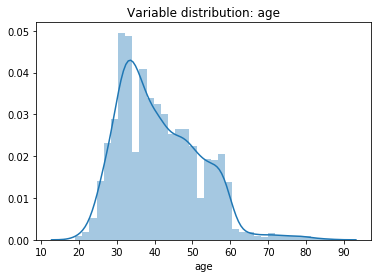

In [83]:
plot_var(df.age, "age")

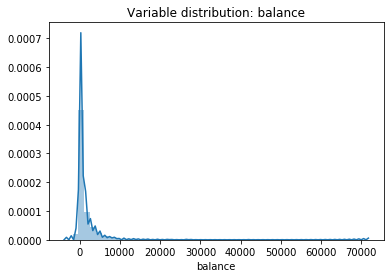

In [84]:
plot_var(df.balance, "balance")

Klienci ze średnim rocznym saldem poniżej 10,000 euro stanowią 98% całości.

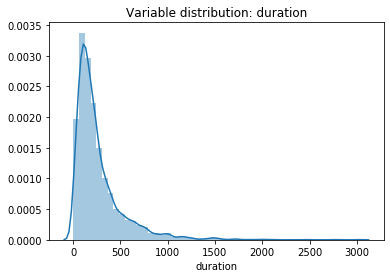

In [85]:
plot_var(df.duration, "duration")

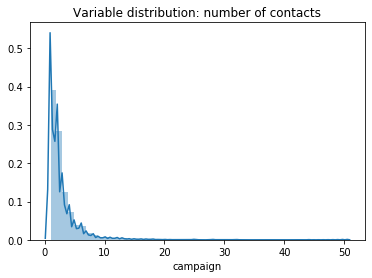

In [86]:
plot_var(df.campaign, "number of contacts")

## Liczba dni od poprzedniego kontaktu
Rozkład dwumodalny dla klientów, z którymi bank kontaktował się w poprzednich kampaniach.

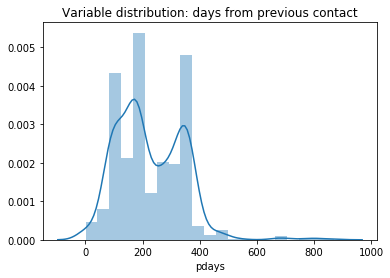

In [87]:
contacted_clients = df[df.pdays >= 0]
plot_var(contacted_clients.pdays, "days from previous contact")

## Brak istotnych zależności pomiędzy zmiennymi ciągłymi

In [88]:
numeric_df = df.select_dtypes(exclude="object")
cor_df = numeric_df.copy()

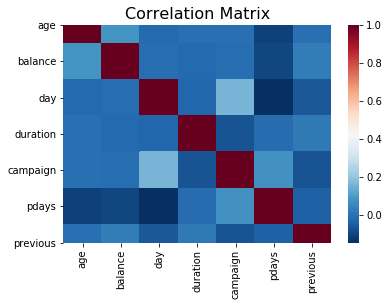

In [89]:
cor_df.pdays[cor_df.pdays == -1] = None
corr_numeric = cor_df.corr()
sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

Wykresy dla par zmiennych również nie pokazały istotnych zależności między nimi.

In [90]:
df.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

In [91]:
def plot_var(col, variable,rotation=False,data=df):
    
    plt.figure(figsize=(10,6))
    plot = sns.countplot(x=col, data=data, palette="muted")
    if rotation:
        plot.set_xticklabels(plot.get_xticklabels(), rotation=30, ha="right")
    plot.set_title("Variable distribution: " + variable)
    plt.tight_layout()

 

def plot_var_vs_target(col,variable,rotation=False,data=df):
    x,y = col, 'y'
    data = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    plot = sns.catplot(data = data, x=x,y='percent',hue=y,kind='bar',height=4, aspect=2,legend_out=False)
    if rotation:
        plot.set_xticklabels(rotation=30)
    plot.fig.suptitle(f'{variable} vs target' ) 
    plt.tight_layout()

def plot_both(column,rotation=False,data=df):
    plot_var(column,column.capitalize(),rotation,data=data)
    plot_var_vs_target(column,column.capitalize(),rotation,data=data)
  

# Zmienne kategoryczne
### Zatrudnienie

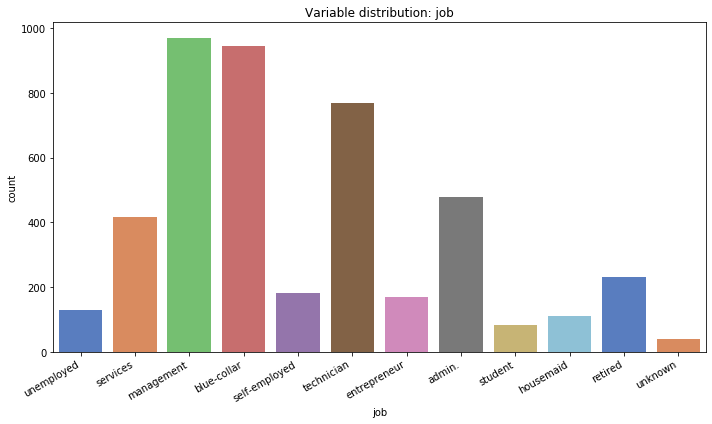

In [92]:
plot_var('job', 'job',rotation=30)

### Zatrudnienie względem zmiennej celu

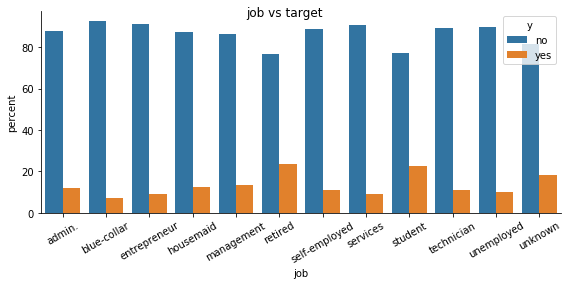

In [93]:
plot_var_vs_target('job','job',rotation=30)


Warto zauważyć, że najwięcej subskrypcji występuje w grupie studentów i emerytów.

## Stan cywilny

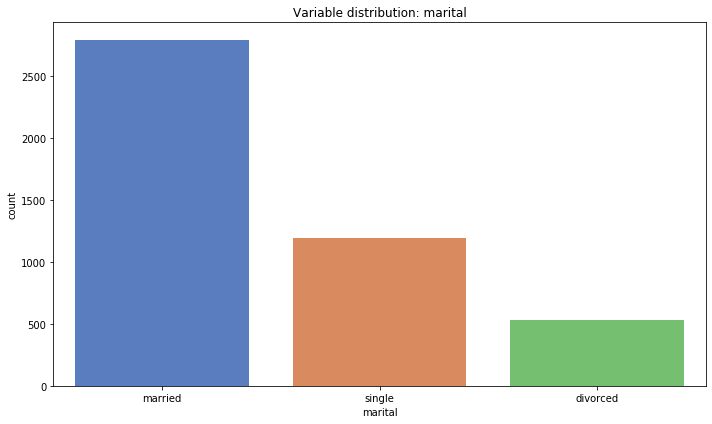

In [94]:
plot_var('marital', 'marital')

In [95]:
(len(df[df.marital=='married'])/len(df.marital))*100

61.86684361866843

Osoby w związku małżeńskim stanowią 62% z całości klientów.

## Wykształcenie

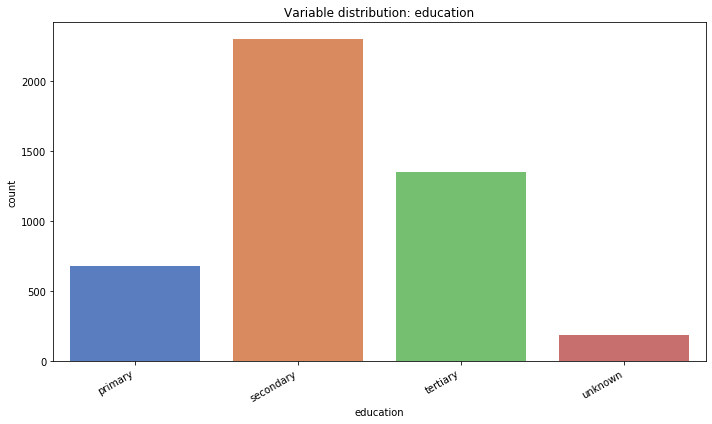

In [96]:
plot_var('education','education',rotation=30)

## Kredyt mieszkaniowy

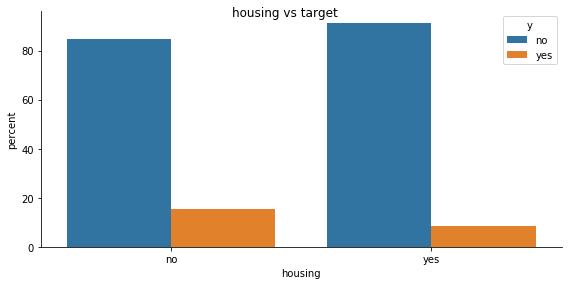

In [97]:
plot_var_vs_target('housing','housing')

## Pożyczka

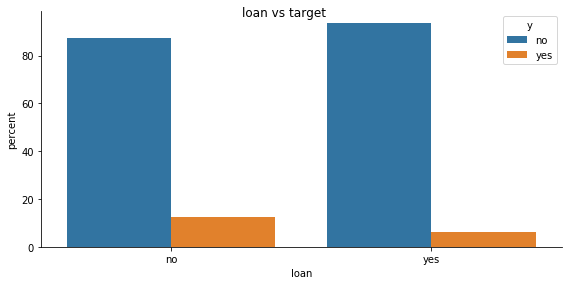

In [98]:
plot_var_vs_target('loan','loan')

Różnice mogą wydawać się niewielkie, lecz późniejsza analiza znaczenia zmiennych pokaże, że te zmienne są istotne dla modelu. 

## Rezultat poprzedniej kampanii

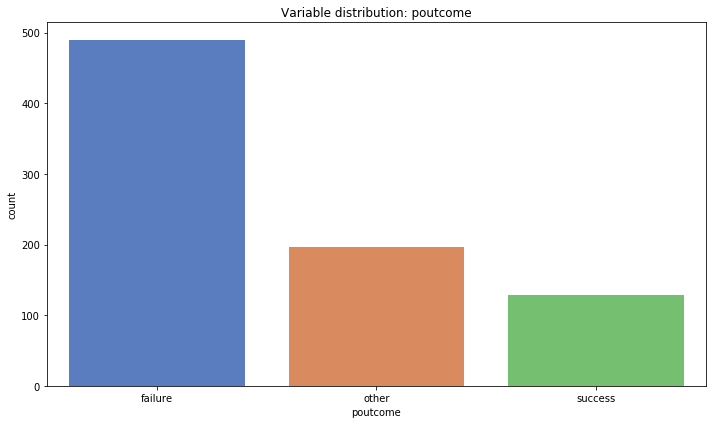

In [99]:
data_help = df[df.poutcome !='unknown']
plot_var('poutcome', 'poutcome', data=data_help)

### Związek ze zmienną celu

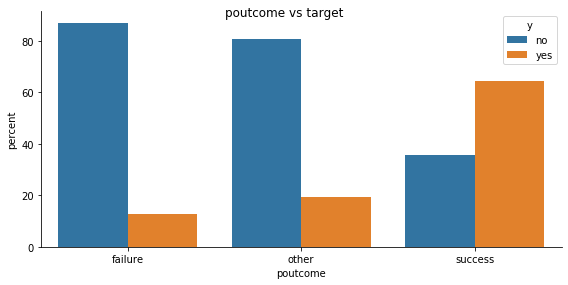

In [100]:
plot_var_vs_target('poutcome', 'poutcome', data=data_help)

Klienci, dla których poprzednia kampania zakończyła się sukcesem, w obecnej również chętniej akceptują subskrypcję.  
Zależność ta okaże się kluczowa dla modelu.

## Zależności między zmiennymi kategorycznymi

### Wiek pomiędzy grupami zawodowymi

In [101]:
def boxes(x,y,hue=None,rotation=False,data=df):
    plt.figure(figsize=(10,6))
    plot = sns.boxplot(x=x,y=y,data=data,palette='muted')
    if rotation:
        plt.setp(plot.get_xticklabels(), rotation=30)
    plt.tight_layout()
    plt.title(f'{x} vs {y}')

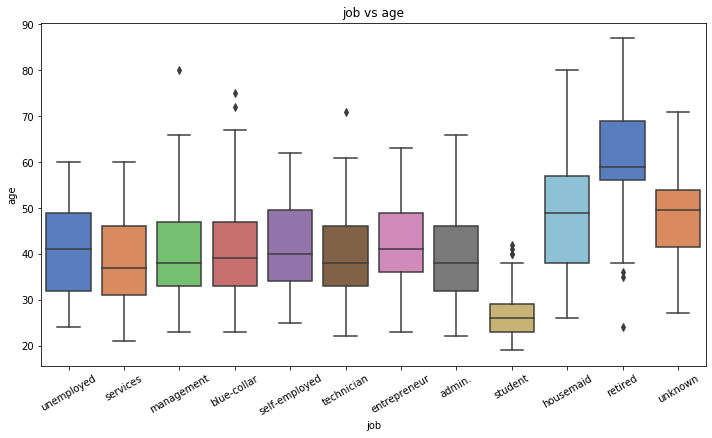

In [102]:
boxes('job','age',rotation=True)


### Saldo względem grup zawodowych

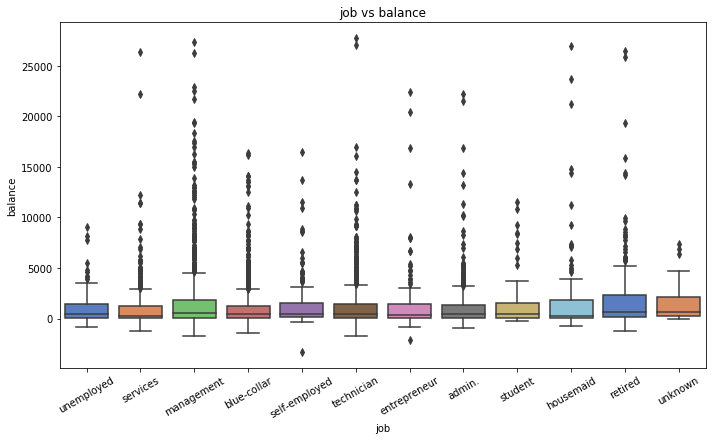

In [103]:
data1 = df[df.balance<30000]
boxes('job','balance',rotation=True,data=data1)

### Wpływ wykształcenia i stanu cywilnego

In [104]:
df['marital/education'] = df['marital'] + "/" + df['education']
education_groups = df.groupby(['marital/education'], as_index=False)['balance'].median()

Text(0.5, 1.0, 'Median Balance by Educational/Marital Group')

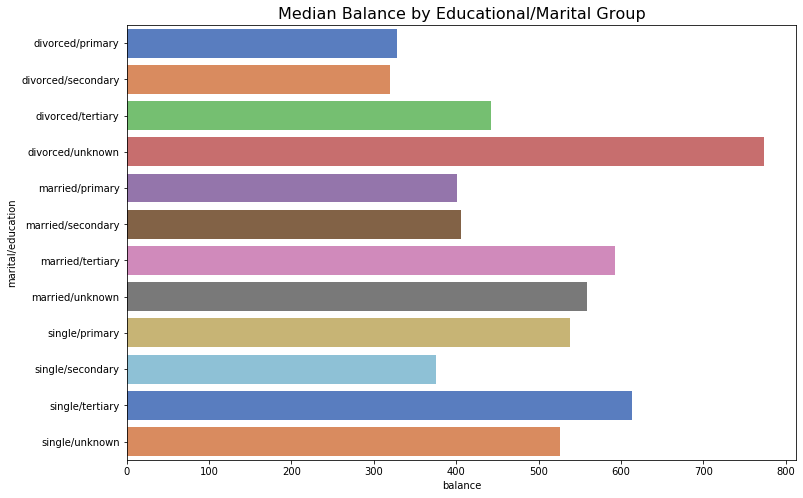

In [105]:
fig = plt.figure(figsize=(12,8))
sns.barplot(x="balance", y="marital/education", data=education_groups, label="Total", palette="muted")
plt.title('Median Balance by Educational/Marital Group', fontsize=16)

## Wpływ długości rozmowy

In [106]:
lst = [df]
df["duration_status"] = np.nan
avg_duration = df['duration'].mean()

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"

In [107]:
def plot_duration():
    pct_term = pd.crosstab(df['duration_status'], df['y']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)
    ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
    plt.title("The Impact of Duration in Opening a Term Deposit", fontsize=18)
    plt.xlabel("Duration Status", fontsize=18);
    plt.ylabel("Percentage (%)", fontsize=18)
    plt.xticks(rotation=0)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

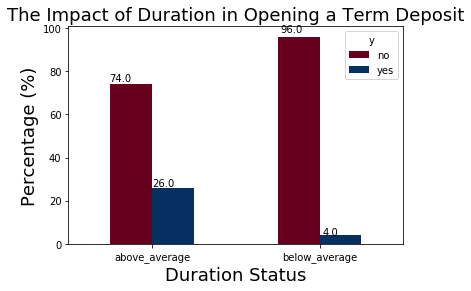

In [108]:
plot_duration()

Dłuższe rozmowy częściej kończą się sukcesem w obecnej kampanii.

# Inżynieria cech
### Podstawowe przekształcenia:
- podział zbioru na treningowy i testowy
- binarne zmienne kategoryczne zakodowane 0-1
- zapis daty numerycznie w osobnych kolumnach
- standaryzacja danych

## Redukcja skośności rozkładów ciągłych
Za pomocą przekształceń Yeo-Johnson i Box-Cox.  
Przykładowe współczynniki skośności dla zbioru treningowego po transformacji.

In [109]:
skew_reduce(X_train, skew_train)

1.290840421959374 balance yeojohnson
0.013448824859416945 duration boxcox
0.16766062091805645 campaign boxcox
1.6668067185477198 pdays yeojohnson
1.6665615521189976 previous yeojohnson


## Optymalne kodowanie zmiennych kategorycznych
Wytrenowanie i ocena modeli na przygotowanych dwóch wersjach zbiorów danych:

1. podejście:
    - target encoding: zmienne z zależnościomi do zmiennej celu
    - one-hot encoding: pozostałe zmienne kategoryczne
2. podejście:
    - target encoding: wszystkie zmienne kategoryczne

## Modele wybrane do ewaluacji
- regresja logistyczna
- XGBoost
- las losowy
  
### Schemat ewaluacji modeli:

1. Kroswalidacja połączona ze strojeniem parametrów na zbiorze treningowym
2. Kalkulacja miar na zbiorze testowym:
    - precision
    - recall
    - accuracy
    - auc
3. Porównanie wyników pomiędzy modelami oraz wersjami inżynierii cech.

In [7]:
TE_OH = pd.read_csv("wer1", index_col=0)

### Rezultat: target encoding + one-hot

In [8]:
TE_OH

,regresja,XGBoost,random forest
precision,0.44,0.75,0.49
recall,0.50,0.68,0.50
accuracy,0.88,0.89,0.90
roc_auc,0.86,0.90,0.87


### Wnioski
- połączenie target encoding z one-hot encoding przyniosło lepsze wyniki niż użycie tylko target encoding
- wyniki osiągane przez modele nie różniły się znacząco
- najlepsze osiągnął XGBoost: wyższe recall i precision

## Analiza znaczenia zmiennych

In [113]:
feat_importances = pd.read_csv("feat_imp", index_col=0)
feat_importances.columns = ["Feature importance"]

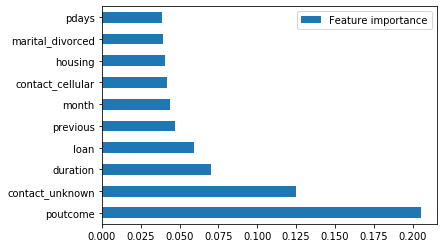

In [114]:
feat_importances.nlargest(10, columns="Feature importance").plot(kind='barh')

### Potwierdzone hipotezy z EDA o wpływie zmiennych:
- wynik poprzedniej kampanii
- długość rozmowy
- pożyczka i kredyt

## Decyzje po etapie inżynierii cech
- model do dalszego rozwoju: XGBoost
- pozostałe modele pozostawimy dla porównania
- będziemy pracować na zbiorze, który umożliwił lepsze wyniki